# Сканнер судоку

 распознаваниt чисел на решетке судоку. 

1. Конвертация в нужное цветовое пространство
2. Поиск решетки на изображении через контуры
3. Перспектива решетки судоку для распознавания
4. Выделение ячеек с числами
5. Обучение нейронной сети на MNIST
6. Распознавание цифр в судоку с помощью сети

## Подготовка 

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def READ_RGB(path):
    image=cv2.imread(path)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def SHOW_IMAGE(image):
    plt.imshow(image,cmap='gray')
    plt.show()

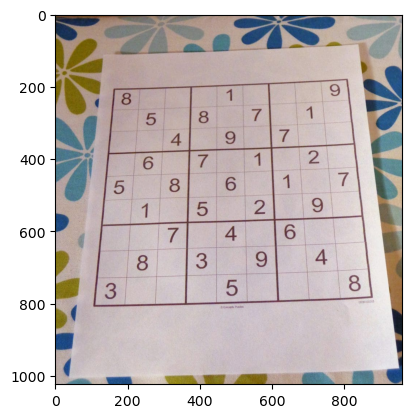

In [3]:
# Загружаем изображение
img_rgb = READ_RGB("img.jpg")
SHOW_IMAGE(img_rgb)

### Бинаризация

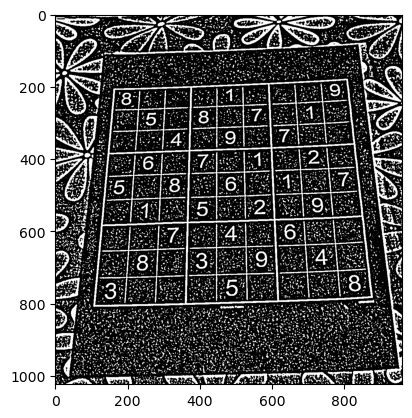

In [4]:
import cv2
import numpy as np

# 1) Перевод RGB - Grayscale
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# 2) размытие,  убираем  мелкий шум (подбираем ядро и σ)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

# 3) Бинаризация. адаптивный порог
img_bin = cv2.adaptiveThreshold(
    img_blur,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,   
    thresholdType=cv2.THRESH_BINARY_INV,         # инверсируем: решётка  белая
    blockSize=11,                                # размер окна (нечётное)
    C=2                                          # смещение порога
)

SHOW_IMAGE(img_bin)


### Поиск контуров

На этом этапе мы хотим найти решетку с судоку. По нашему предположению, это наибольший по площади четырехугольник

In [5]:
# Функция для уменьшения ребер в контуре, как на предыдущей лабе
def Approximating(contour,epsilon=.1):
    # Периметр контура
    length=cv2.arcLength(contour,True)
    # Аппроксимирует контурную форму к форме с меньшим количеством вершин 
    # в зависимости от указанной точности. Это реализация алгоритма Рамера — Дугласа — Пекера.
    approx=cv2.approxPolyDP(contour,epsilon*length,True)
    return approx

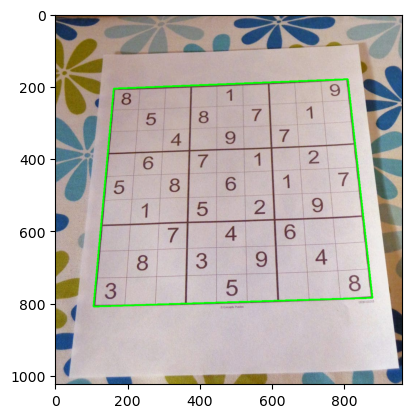

In [6]:
# Поиск контуров на  изображении
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Сортировка контуров по площади
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Предполагаем, что самый большой контур — это решетка судоку
sudoku_contour = contours[0]

# Аппроксимация до 4-х угольника
approx = Approximating(sudoku_contour, epsilon=0.02)  #  ε в зависимости от результата

# контур на копии  изображения
img_contour = img_rgb.copy()
cv2.drawContours(img_contour, [approx], -1, (0, 255, 0), 3)

SHOW_IMAGE(img_contour)


### WarpTransform

На этом этапе, мы сделаем перспективу решетки на новое изображение. Размерность нового изображения мы можем задать сами, поэтому упростим себе жизнь: пусть размер каждой ячейки будет 28x28, чтобы без лишних трансформаций отправлять их в нейронную сеть. Количество ячеек в судоку - 9 на 9. Таким образом, длина и ширина изображения будут 9x28 (мы не учитываем толщину линий между ячейчками)

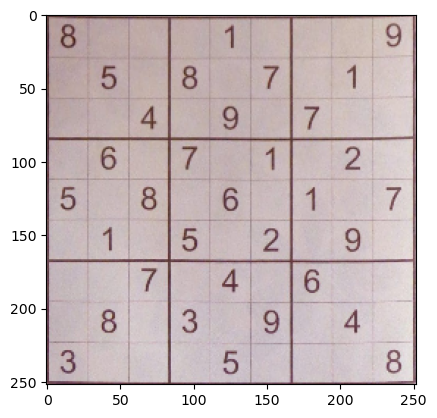

In [7]:
img_contours = img_rgb.copy()

def sort_points(pts):
    # Преобразуем в плоский массив
    pts = pts.reshape(4, 2)
    # Сортируем по сумме и разности координат
    sum_pts = pts.sum(axis=1)
    diff_pts = np.diff(pts, axis=1)
    
    top_left = pts[np.argmin(sum_pts)]
    bottom_right = pts[np.argmax(sum_pts)]
    top_right = pts[np.argmin(diff_pts)]
    bottom_left = pts[np.argmax(diff_pts)]
    
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

# Упорядочим углы
pts_src = sort_points(approx)

# Задаем координаты для новой решётки
output_size = 28 * 9  
pts_dst = np.array([
    [0, 0],
    [output_size - 1, 0],
    [output_size - 1, output_size - 1],
    [0, output_size - 1]
], dtype='float32')

# Матрица преобразования
M = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Перспективное преобразование
warped = cv2.warpPerspective(img_contours, M, (output_size, output_size))

SHOW_IMAGE(warped)


### Разделение

Дальше ячейки будем делить не по линиям на изображении, а по предварительным расчетам, что каждая цифра находится в ячейке размером 28 на 28, а размерность решетки судоку 9 на 9

В ячейки может попасть мусор в виде границ между ячейками. От него можно избавиться с помощью великолепной функции `clear_border`, которая удаляет все ненужные части изображения по краям. 

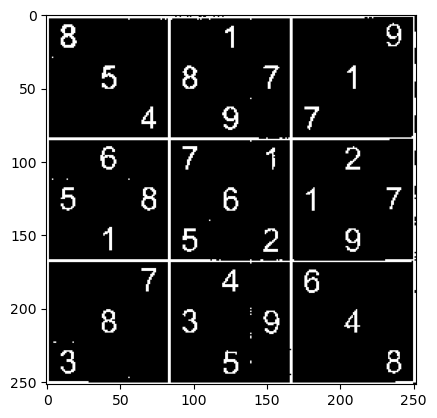

In [8]:
gray = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
_, warped_binary = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
SHOW_IMAGE(warped_binary)

In [9]:
from skimage.segmentation import clear_border

nRows, nCols = 9, 9
cell_size = 28          
margin = 2               # отступ от линий сетки, чтобы не захватывать рамку

grid = []
for i in range(nRows):
    row = []
    for j in range(nCols):
        # координаты углов ячейки в глобальном изображении
        y_start = i * cell_size + margin
        y_end   = (i + 1) * cell_size - margin
        x_start = j * cell_size + margin
        x_end   = (j + 1) * cell_size - margin

        # вырезаем под-изображение и чистим рамки, которые могли остаться
        subImg = warped_binary[y_start:y_end, x_start:x_end]
        subImg = clear_border(subImg)       # убираем белые пиксели, по краям
        row.append(subImg)
    grid.append(row)


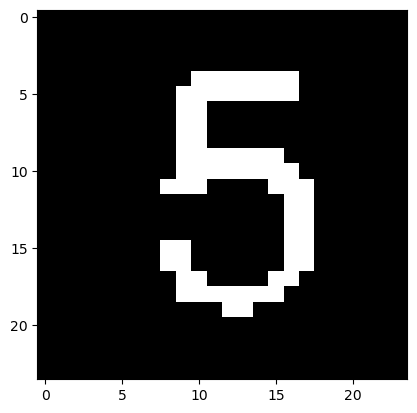

In [10]:
SHOW_IMAGE(grid[4][0])

## Обучение сети для распознавания

Обучим простую сеть для распознавания цифр на MNIST. 

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.001
num_epochs = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize model, loss function and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100.*accuracy:.0f}%)\n')

# Train the model
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training completed!")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295181
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.070241
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.268611
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.125500
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.216894
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.165191
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.096744
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.137996
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.071688
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.113692

Test set: Average loss: 0.1292, Accuracy: 9590/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.152585
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.141462
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.146507
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.204686
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.088683
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.005450
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.075763
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.339879
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.083560
T

## Итоговое распознавание

Теперь мы можем проверить, как работает нейронка на кусках изображения из нашего судоку.  
Поскольку у модели нет класса "пустое изображение", которые встречается в нашем случае, придется отфильтровывать такие ячейки.  
Мы сделаем это из предположение, что если в ячейке нет контуров, то она пустая.

Some number in cell 0 0. Predicted: 7


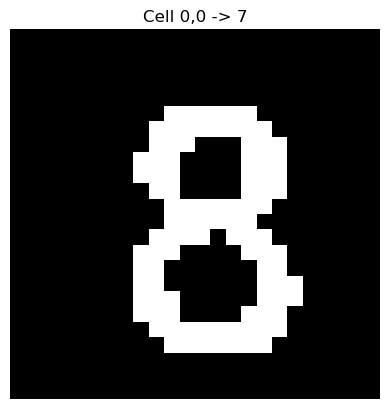

Empty cell 0 1
Empty cell 0 2
Empty cell 0 3
Some number in cell 0 4. Predicted: 3


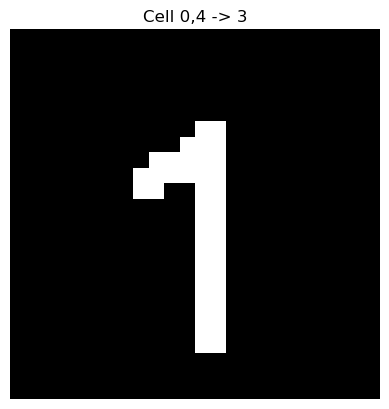

Empty cell 0 5
Empty cell 0 6
Empty cell 0 7
Some number in cell 0 8. Predicted: 3


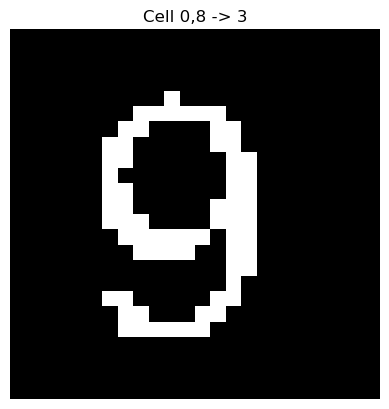

Empty cell 1 0
Some number in cell 1 1. Predicted: 3


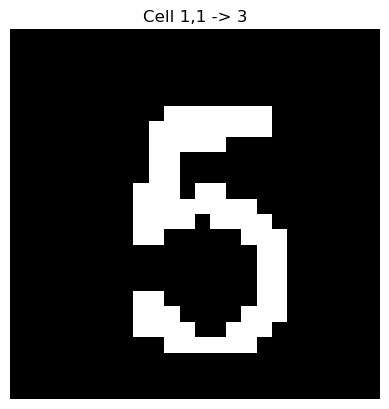

Empty cell 1 2
Some number in cell 1 3. Predicted: 3


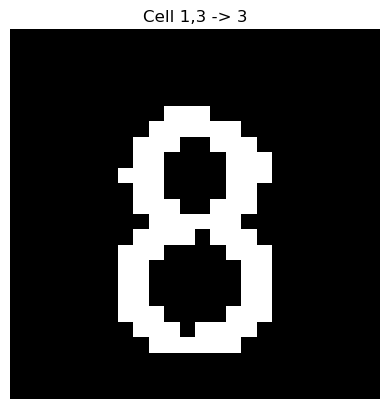

Empty cell 1 4
Some number in cell 1 5. Predicted: 7


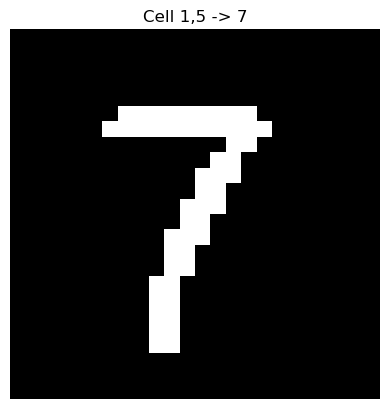

Empty cell 1 6
Some number in cell 1 7. Predicted: 3


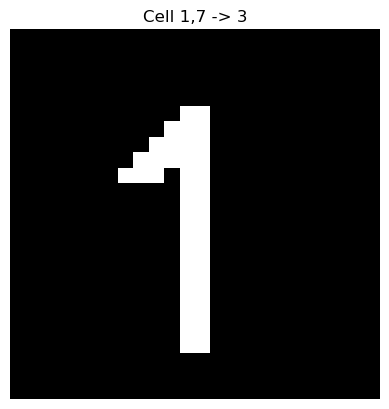

Empty cell 1 8
Empty cell 2 0
Empty cell 2 1
Some number in cell 2 2. Predicted: 3


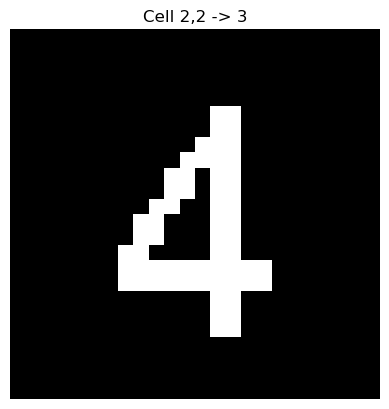

Empty cell 2 3
Some number in cell 2 4. Predicted: 3


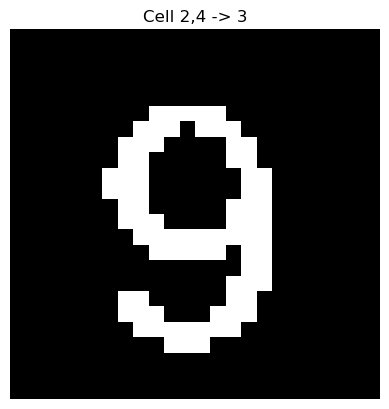

Empty cell 2 5
Some number in cell 2 6. Predicted: 7


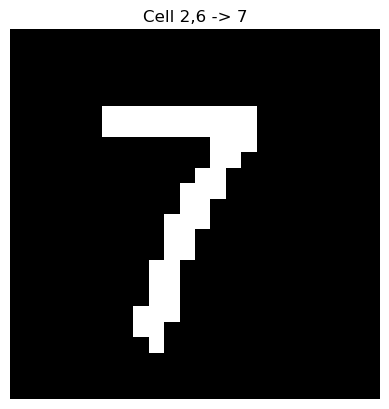

Empty cell 2 7
Empty cell 2 8
Empty cell 3 0
Some number in cell 3 1. Predicted: 3


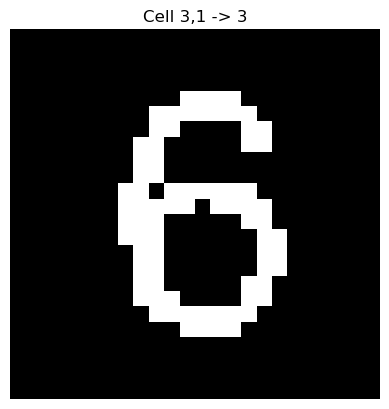

Empty cell 3 2
Some number in cell 3 3. Predicted: 7


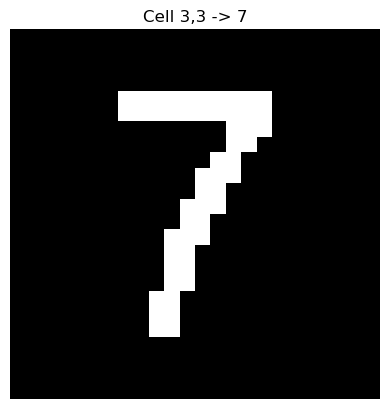

Empty cell 3 4
Some number in cell 3 5. Predicted: 3


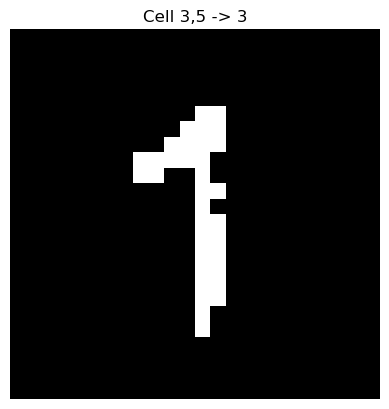

Empty cell 3 6
Some number in cell 3 7. Predicted: 7


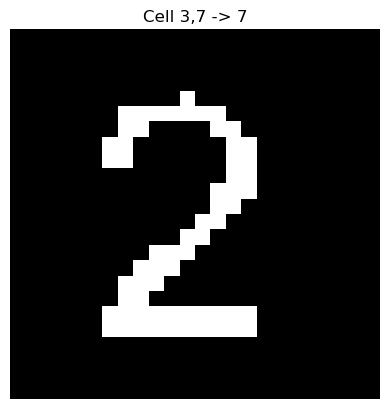

Empty cell 3 8
Some number in cell 4 0. Predicted: 3


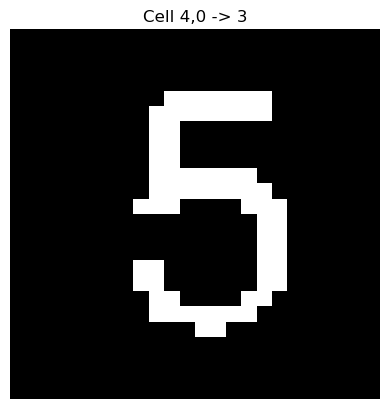

Empty cell 4 1
Some number in cell 4 2. Predicted: 3


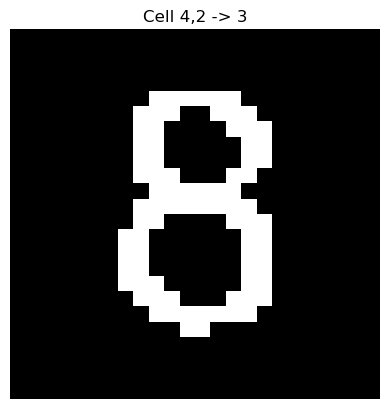

Empty cell 4 3
Some number in cell 4 4. Predicted: 3


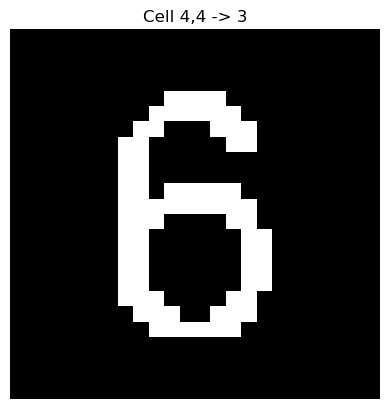

Empty cell 4 5
Some number in cell 4 6. Predicted: 7


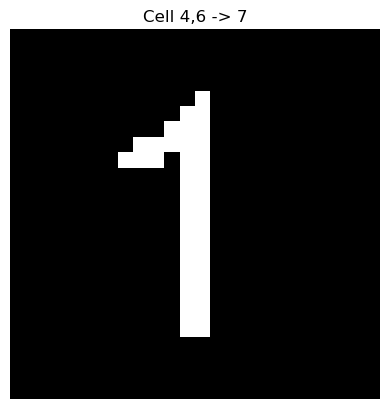

Empty cell 4 7
Some number in cell 4 8. Predicted: 7


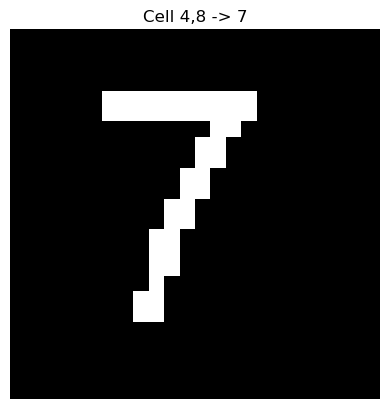

Empty cell 5 0
Some number in cell 5 1. Predicted: 3


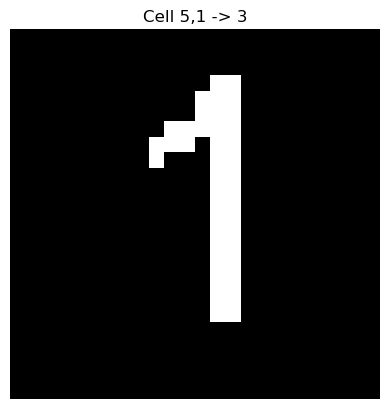

Empty cell 5 2
Some number in cell 5 3. Predicted: 3


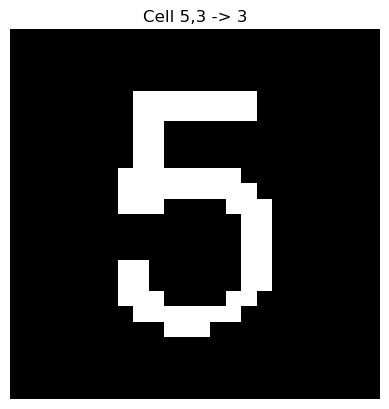

Empty cell 5 4
Some number in cell 5 5. Predicted: 7


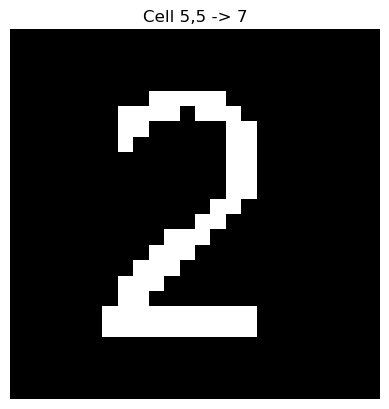

Empty cell 5 6
Some number in cell 5 7. Predicted: 3


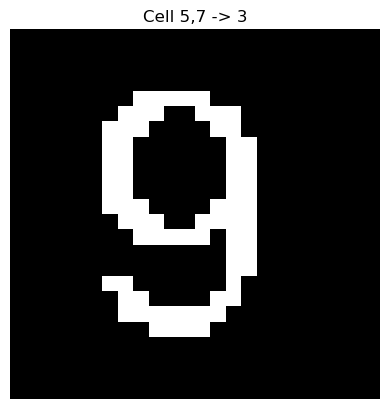

Empty cell 5 8
Empty cell 6 0
Empty cell 6 1
Some number in cell 6 2. Predicted: 7


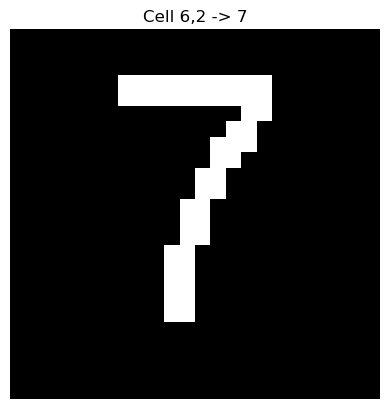

Empty cell 6 3
Some number in cell 6 4. Predicted: 3


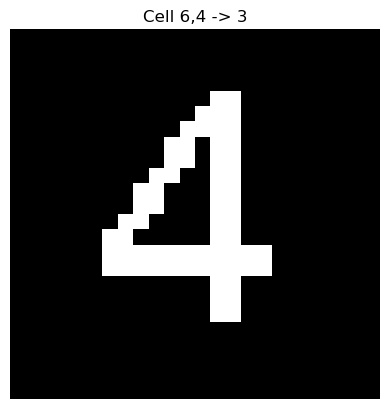

Empty cell 6 5
Some number in cell 6 6. Predicted: 3


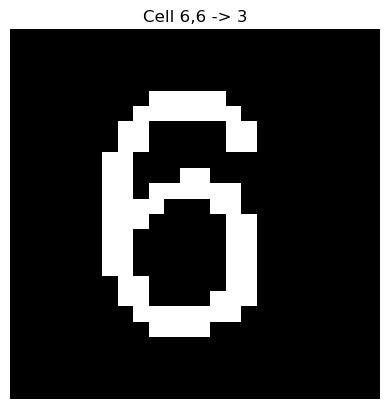

Empty cell 6 7
Empty cell 6 8
Empty cell 7 0
Some number in cell 7 1. Predicted: 3


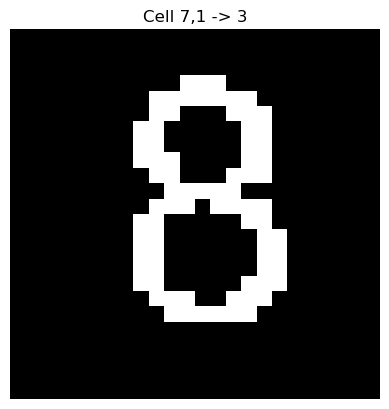

Empty cell 7 2
Some number in cell 7 3. Predicted: 3


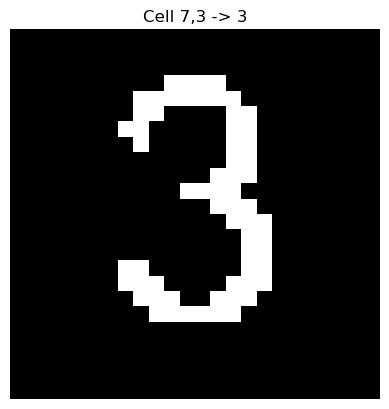

Empty cell 7 4
Some number in cell 7 5. Predicted: 3


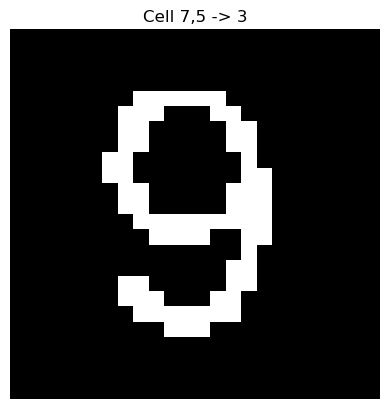

Empty cell 7 6
Some number in cell 7 7. Predicted: 3


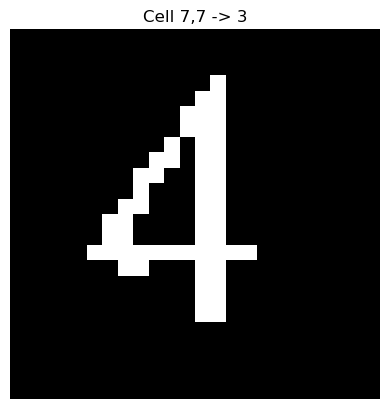

Empty cell 7 8
Some number in cell 8 0. Predicted: 3


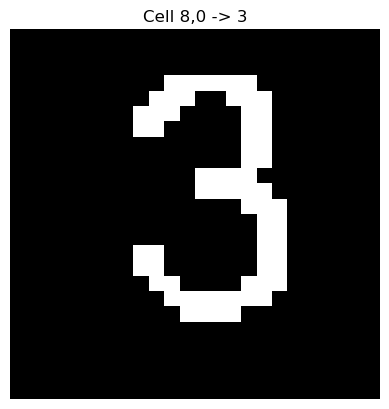

Empty cell 8 1
Empty cell 8 2
Empty cell 8 3
Some number in cell 8 4. Predicted: 3


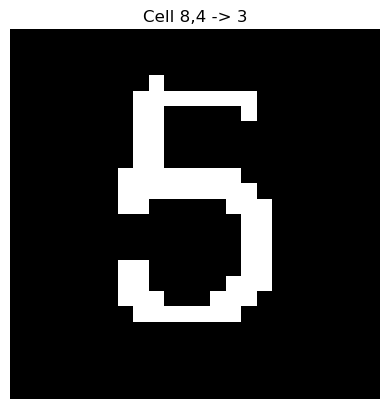

Empty cell 8 5
Empty cell 8 6
Empty cell 8 7
Some number in cell 8 8. Predicted: 3


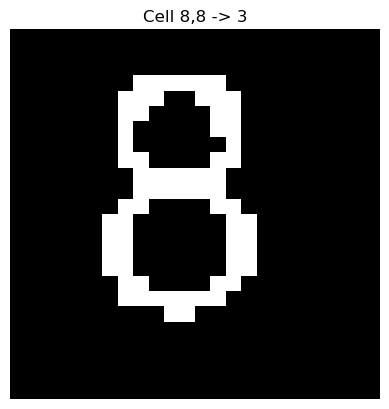

In [12]:
import matplotlib.pyplot as plt

def preprocess_cell(img_bin: np.ndarray) -> torch.Tensor:
    """
    Преобразует бинарную ячейку 0/255 → тензор 1*1*28*28,
    нормализованный как в MNIST.
    """
    img = 255 - img_bin                             # инверсия: белая цифра – чёрный фон
    img = cv2.resize(img, (28, 28), cv2.INTER_AREA) # приводим к 28×28

    img = torch.tensor(img, dtype=torch.float32, device=device) / 255.0  # [0;1]
    img = (img - 0.1307) / 0.3081                   # нормализация
    return img.unsqueeze(0).unsqueeze(0)            # (1, 1, 28, 28)
   


model.eval()

for i in range(nRows):
    for j in range(nCols):
        cell_np = grid[i][j]               # numpy (28, 28)

        # пропускаем  пустые клетки
        if cell_np.sum() < 20:
            print(f"Empty cell {i} {j}")
            continue

        tensor = preprocess_cell(cell_np)  # (1, 1, 28, 28)

        with torch.no_grad():
            logits = model(tensor)
            pred   = logits.argmax(dim=1).item()

        print(f"Some number in cell {i} {j}. Predicted: {pred}")

        # показать картинку
        plt.imshow(cell_np, cmap='gray')
        plt.title(f"Cell {i},{j} -> {pred}")
        plt.axis('off')
        plt.show()




# Результат плохой  

### Поменяем модель  на CNN

# CNN

## Модель

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    # transforms.RandomAffine(
    #     degrees=5,               # повороты 
    # ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# CNN
class CNN(nn.Module):
    def __init__(self, p_drop_conv=0.25, p_drop_fc=0.5):
        super().__init__()

        # feature extractor 
        self.features = nn.Sequential(
            # блок 1
            nn.Conv2d(1, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(p_drop_conv),

            # блок 2
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(p_drop_conv),
        )

        # глобальное усреднение (делает сеть независимой от точного размера входа)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))   # 64*1*1

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop_fc),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)            # B * 64 * H' * W'
        x = self.pool(x)                # B * 64 * 1 * 1
        x = x.flatten(1)                # B * 64
        return self.classifier(x)


model = CNN().to(device)

## Тренировка

In [15]:
transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=5,               # небольшие повороты
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


batch_size   = 32
lr           = 0.005
epochs       = 15



train_ds = torchvision.datasets.MNIST('./data', train=True,
                                      download=True, transform=transform)
test_ds  = torchvision.datasets.MNIST('./data', train=False,
                                      download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)




criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.7) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)

    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

        pbar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    avg_loss = total_loss / len(train_loader)
    acc = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)


def test():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Validation", leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(test_loader)
    acc = 100. * correct / total
    val_losses.append(avg_loss)
    val_accuracies.append(acc)

    print(f'Val loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%')
    return avg_loss 

def func_train():
    for epoch in range(1, epochs+1):
        train(epoch)
        print(f"Эпоха: {epoch}")
        val_loss = test()
        scheduler.step(val_loss)
        
        # scheduler.step()


    torch.save(model.state_dict(), 'mnist_cnn.pth')
    print('Обучение завершено и модель сохранена.')


    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# func_train()

In [16]:

import cv2

def preprocess_cell(img_bin):
    """
    img_bin – np.array (H, W) 0/255.
    torch.Tensor shape 1*28*28
    """
    img = 255 - img_bin                         # инверсия: белая цифра на чёрном
    img = cv2.resize(img, (28, 28),            
                     interpolation=cv2.INTER_AREA)

    img = torch.tensor(img, dtype=torch.float32) / 255.0
    img = (img - 0.1307) / 0.3081               # нормализация
    return img.unsqueeze(0)                     # C=1



model.eval()
sudoku_digits = np.zeros((9, 9), dtype=int)

with torch.no_grad():
    for i in range(9):
        for j in range(9):
            cell = grid[i][j]
            if cell.sum() < 20:        #  пусто
                sudoku_digits[i, j] = 0
                continue
            tensor = preprocess_cell(cell).to(device).unsqueeze(0)  # B×C×H×W
            logits = model(tensor)
            pred = logits.argmax(1).item()
            sudoku_digits[i, j] = pred

print(sudoku_digits)


[[1 0 0 0 1 0 0 0 1]
 [0 1 0 1 0 1 0 1 0]
 [0 0 1 0 1 0 1 0 0]
 [0 1 0 1 0 1 0 1 0]
 [1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0]
 [0 0 1 0 1 0 1 0 0]
 [0 1 0 1 0 1 0 1 0]
 [1 0 0 0 1 0 0 0 1]]


## Распознавание



Some number in cell 0 0. Predicted: 1


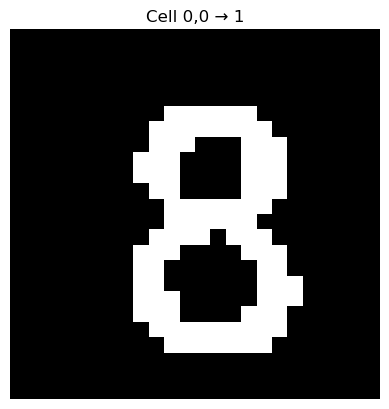

Empty cell 0 1
Empty cell 0 2
Empty cell 0 3
Some number in cell 0 4. Predicted: 1


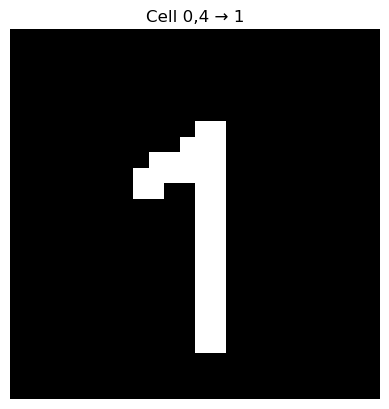

Empty cell 0 5
Empty cell 0 6
Empty cell 0 7
Some number in cell 0 8. Predicted: 1


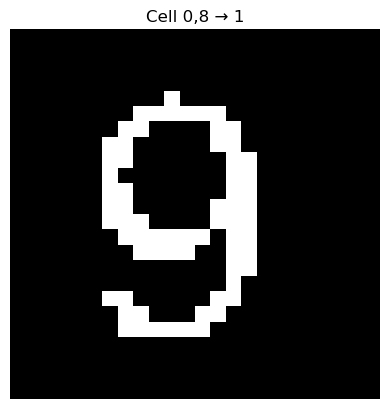

Empty cell 1 0
Some number in cell 1 1. Predicted: 1


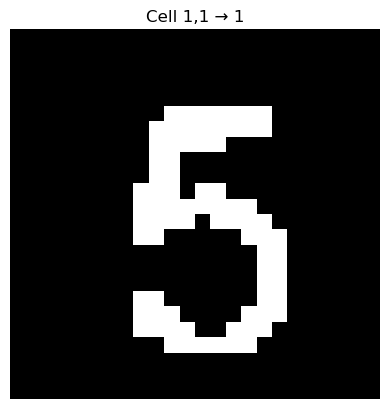

Empty cell 1 2
Some number in cell 1 3. Predicted: 1


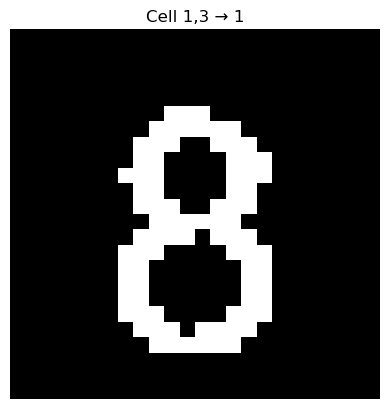

Empty cell 1 4
Some number in cell 1 5. Predicted: 1


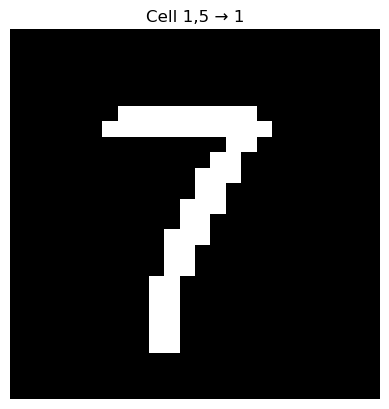

Empty cell 1 6
Some number in cell 1 7. Predicted: 1


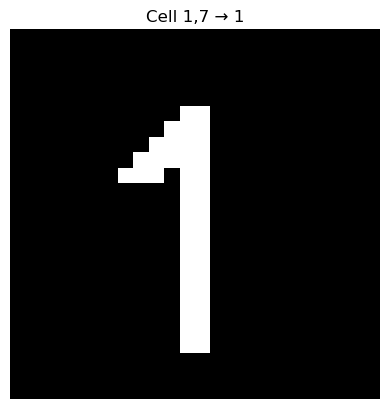

Empty cell 1 8
Empty cell 2 0
Empty cell 2 1
Some number in cell 2 2. Predicted: 1


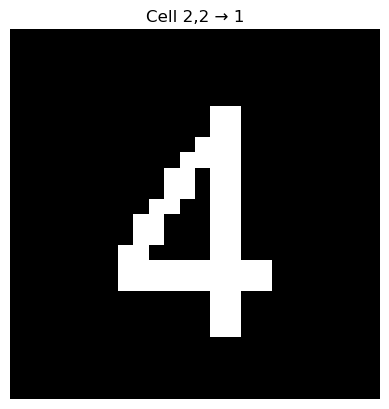

Empty cell 2 3
Some number in cell 2 4. Predicted: 1


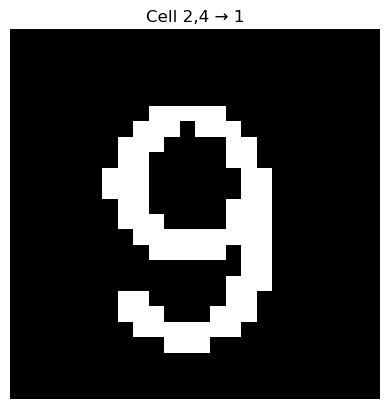

Empty cell 2 5
Some number in cell 2 6. Predicted: 1


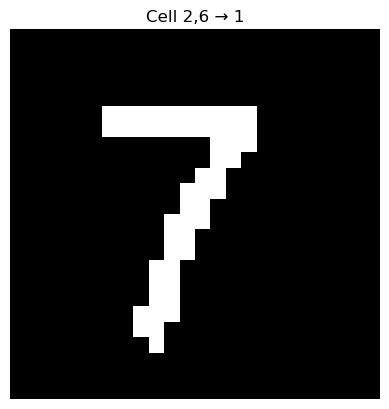

Empty cell 2 7
Empty cell 2 8
Empty cell 3 0
Some number in cell 3 1. Predicted: 1


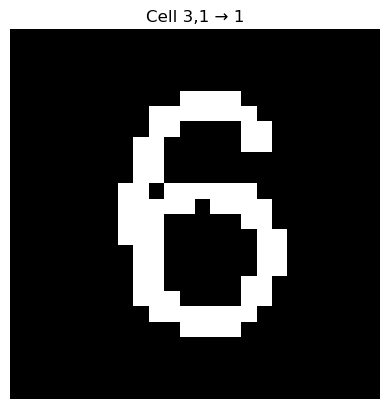

Empty cell 3 2
Some number in cell 3 3. Predicted: 1


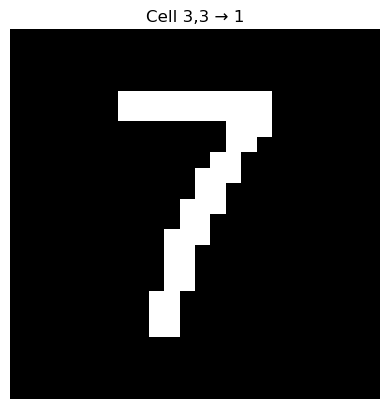

Empty cell 3 4
Some number in cell 3 5. Predicted: 1


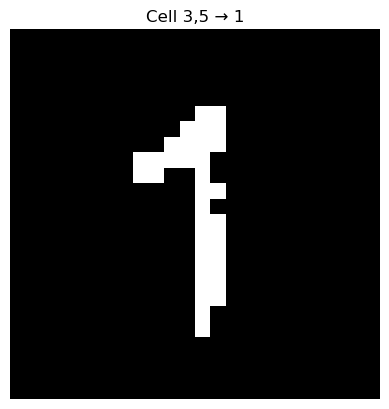

Empty cell 3 6
Some number in cell 3 7. Predicted: 1


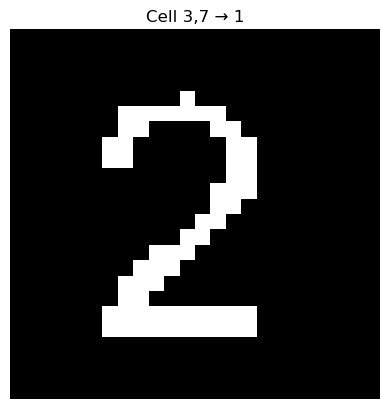

Empty cell 3 8
Some number in cell 4 0. Predicted: 1


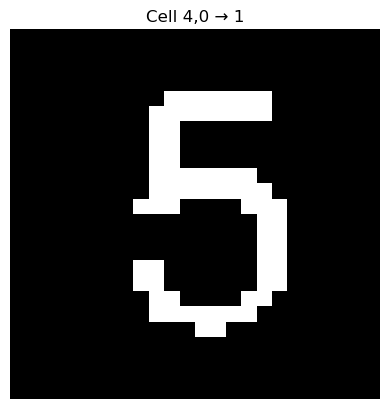

Empty cell 4 1
Some number in cell 4 2. Predicted: 1


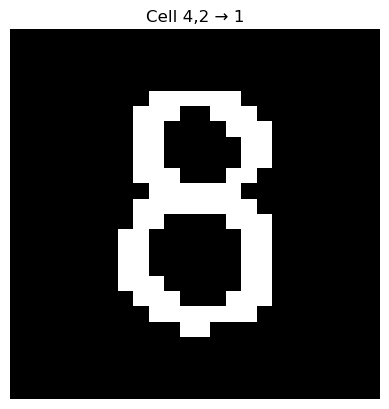

Empty cell 4 3
Some number in cell 4 4. Predicted: 1


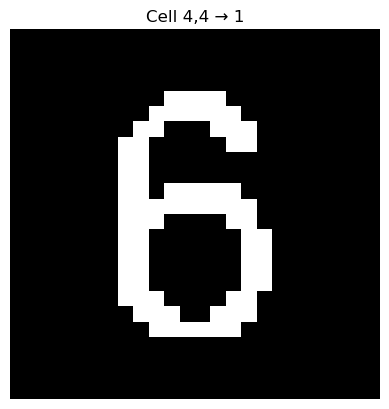

Empty cell 4 5
Some number in cell 4 6. Predicted: 1


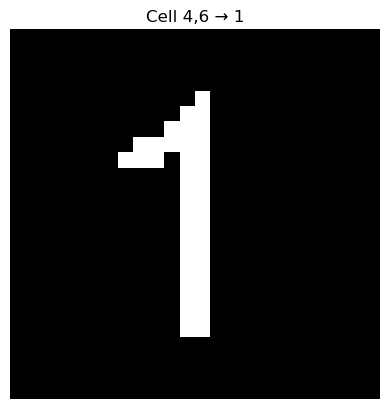

Empty cell 4 7
Some number in cell 4 8. Predicted: 1


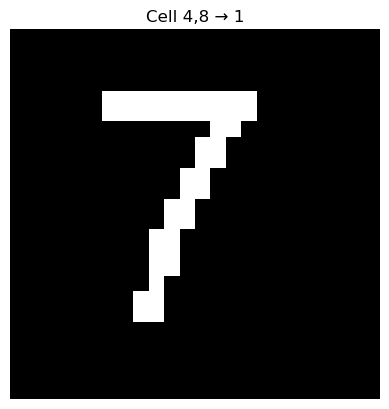

Empty cell 5 0
Some number in cell 5 1. Predicted: 1


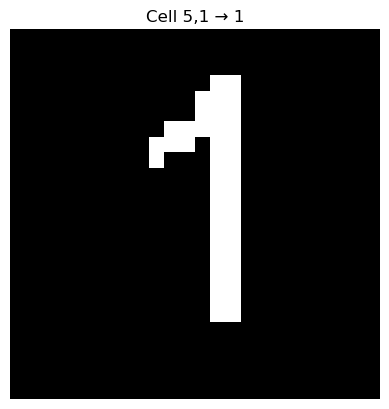

Empty cell 5 2
Some number in cell 5 3. Predicted: 1


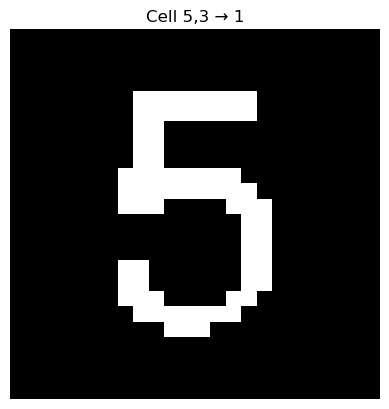

Empty cell 5 4
Some number in cell 5 5. Predicted: 1


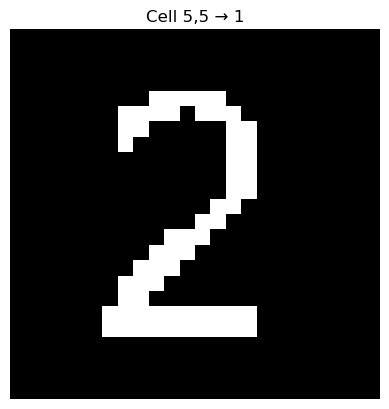

Empty cell 5 6
Some number in cell 5 7. Predicted: 1


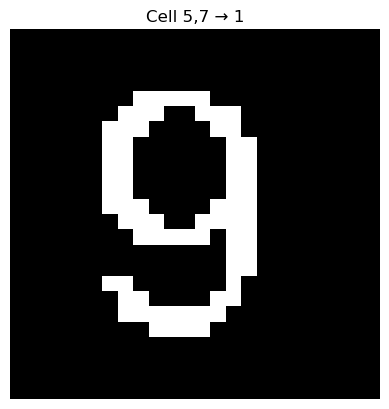

Empty cell 5 8
Empty cell 6 0
Empty cell 6 1
Some number in cell 6 2. Predicted: 1


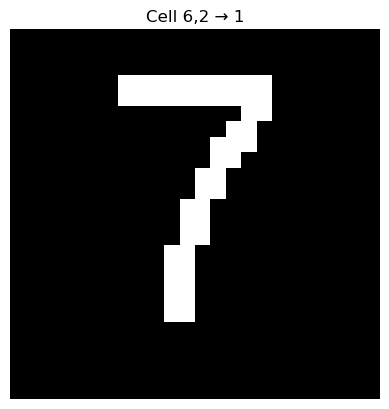

Empty cell 6 3
Some number in cell 6 4. Predicted: 1


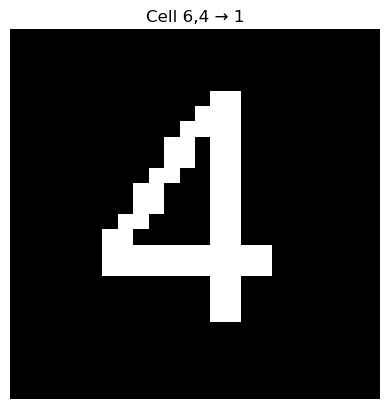

Empty cell 6 5
Some number in cell 6 6. Predicted: 1


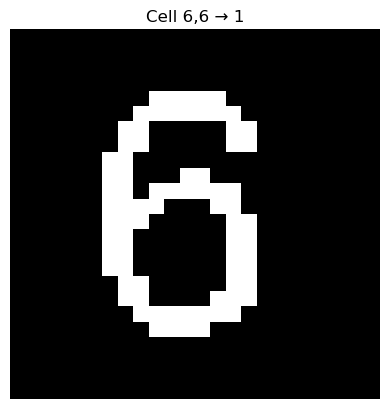

Empty cell 6 7
Empty cell 6 8
Empty cell 7 0
Some number in cell 7 1. Predicted: 1


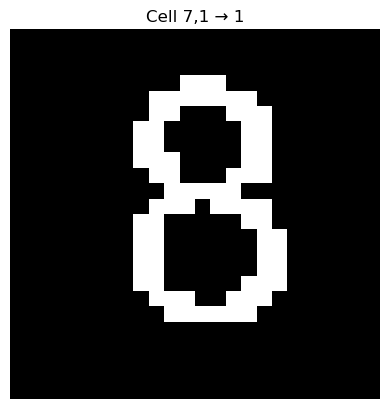

Empty cell 7 2
Some number in cell 7 3. Predicted: 1


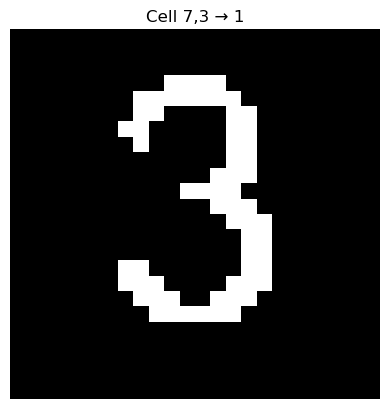

Empty cell 7 4
Some number in cell 7 5. Predicted: 1


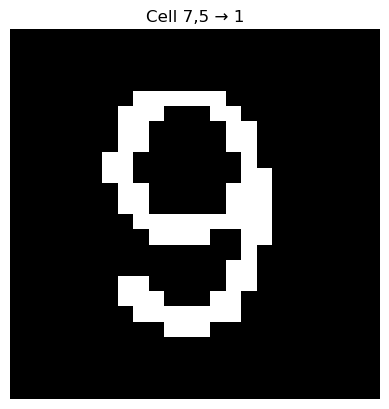

Empty cell 7 6
Some number in cell 7 7. Predicted: 1


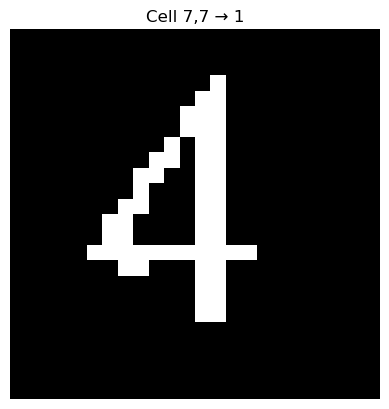

Empty cell 7 8
Some number in cell 8 0. Predicted: 1


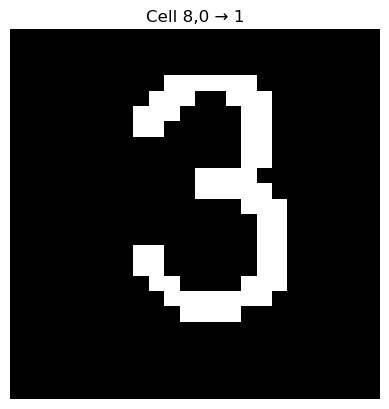

Empty cell 8 1
Empty cell 8 2
Empty cell 8 3
Some number in cell 8 4. Predicted: 1


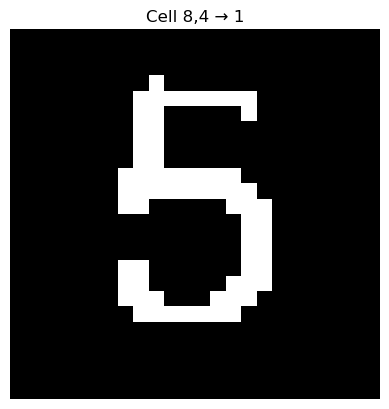

Empty cell 8 5
Empty cell 8 6
Empty cell 8 7
Some number in cell 8 8. Predicted: 1


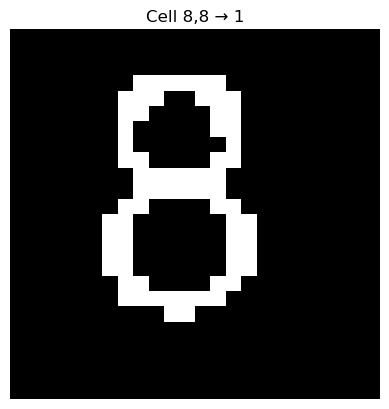

In [ ]:
import matplotlib.pyplot as plt

model.eval()

for i in range(nRows):
    for j in range(nCols):
        bb = grid[i][j]  # (28, 28) numpy-массив

        if bb.sum() < 20:  # если  нет белых  пикселей — пустая ячейка
            print(f"Empty cell {i} {j}")
            continue

        # Иначе — есть цифра
        tensor = preprocess_cell(bb).to(device).unsqueeze(0)  # (1, 1, 28, 28)

        with torch.no_grad():
            logits = model(tensor)
            pred = logits.argmax(1).item()

        print(f"Some number in cell {i} {j}. Predicted: {pred}")

        # Показываем изображение
        plt.imshow(bb, cmap='gray')
        plt.title(f"Cell {i},{j} → {pred}")
        plt.axis('off')
        plt.show()


# Результат плохой

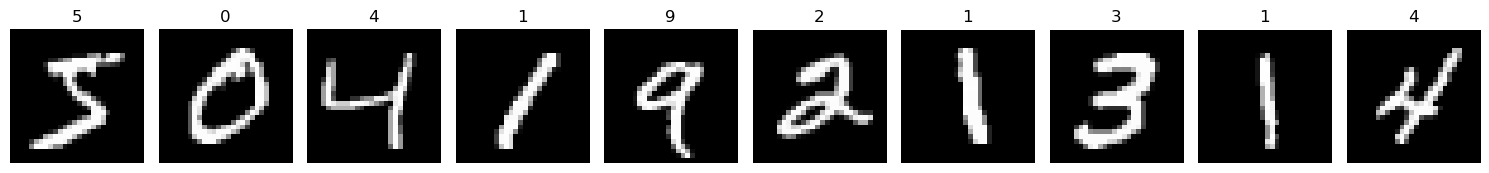

In [18]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Трансформация: превращает изображение в тензор и нормализует как в MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Загрузка обучающего набора MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Вывод первых 10 изображений
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img, label = mnist_train[i]
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(str(label))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## В MNIST цифры рукописные  
#### в судоку цифры печатные, нужно добавить изображения с печатными цифравми разных шрифтов  
#### Используем шрифты системы для генерации изображений с аугментациями   

# Добавление шрифтов

## Датасет

Используем шрифты: ['/usr/share/fonts/truetype/libreoffice/opens___.ttf', '/usr/share/fonts/truetype/freefont/FreeSans.ttf', '/usr/share/fonts/truetype/freefont/FreeMono.ttf', '/usr/share/fonts/truetype/freefont/FreeSerif.ttf', '/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf', '/usr/share/fonts/truetype/freefont/FreeSerifItalic.ttf', '/usr/share/fonts/truetype/freefont/FreeSansOblique.ttf', '/usr/share/fonts/truetype/freefont/FreeSansBoldOblique.ttf', '/usr/share/fonts/truetype/freefont/FreeMonoOblique.ttf', '/usr/share/fonts/truetype/freefont/FreeSerifBoldItalic.ttf', '/usr/share/fonts/truetype/freefont/FreeMonoBoldOblique.ttf', '/usr/share/fonts/truetype/freefont/FreeMonoBold.ttf', '/usr/share/fonts/truetype/freefont/FreeSansBold.ttf', '/usr/share/fonts/truetype/ubuntu/UbuntuSansMono-Italic[wght].ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf', '/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-Italic[wdth,wght].ttf', '/usr/sha

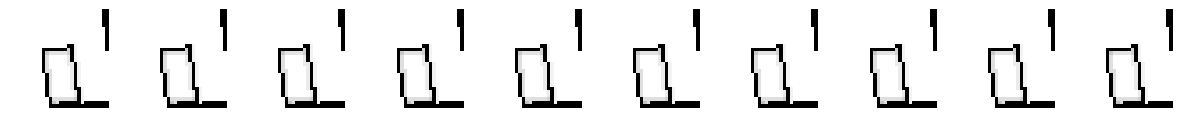

In [19]:
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

class MNISTWrapper(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist = mnist_dataset
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        # label - int, превращаем в тензор
        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Параметры
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
IMG_SIZE = 28
FONTS_DIR = "/usr/share/fonts/truetype/"  #  папка с шрифтами в системе

# Найдем  ttf шрифты в системе 
def find_ttf_fonts(dir_path, max_fonts=5):
    fonts = []
    for root, _, files in os.walk(dir_path):
        for file in files:
            if file.endswith(".ttf"):
                fonts.append(os.path.join(root, file))
                if len(fonts) >= max_fonts:
                    return fonts
    return fonts

fonts = find_ttf_fonts(FONTS_DIR, max_fonts=70)  # max_fonts=70 количество шрифтов в системе
print("Используем шрифты:", fonts)

# Создание изображения цифры с заданным шрифтом
def create_digit_image(digit, font_path, size=28):
    img = Image.new('L', (size, size), color=255)  # белый фон
    draw = ImageDraw.Draw(img)
    font_size = int(size * 0.8)
    font = ImageFont.truetype(font_path, font_size)
    
    # Получаем bounding box текста
    bbox = draw.textbbox((0, 0), str(digit), font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Рисуем текст по центру
    draw.text(((size - w) / 2, (size - h) / 2), str(digit), fill=0, font=font)  # черная цифра
    
    return img


# Аугментация 
aug = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.15)),
])

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

images, labels = [], []

for digit in range(10):
    for font_path in fonts:
        base_img = create_digit_image(digit, font_path)
        # оригинал
        images.append(to_tensor(base_img))
        labels.append(digit)

        # аугментации,  25 на каждый оригинал
        pil_to_tensor = transforms.ToTensor()
        for _ in range(25):
            aug_img = aug(base_img)
            images.append(to_tensor(aug_img))
            labels.append(digit)

images = torch.stack(images)  # (N,1,28,28)
labels = torch.tensor(labels, dtype=torch.long)

print(f"Сгенерировано изображений: {len(images)}")

printed_digits_dataset = TensorDataset(images, labels)

print("\nОбразец цифр:")
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img = images[3000].squeeze().numpy()  # тензор с размерностью (1, 28, 28)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.show()


In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.001
num_epochs = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())


In [21]:
from torch.utils.data import ConcatDataset, DataLoader
import torch, cv2
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset

class MNISTWrapper(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist = mnist_dataset
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        # label - int, превращаем в тензор
        label = torch.tensor(label, dtype=torch.long)
        return img, label

mnist_train_wrapped = MNISTWrapper(train_dataset)

# Объединяем датасеты для train
combined_dataset = ConcatDataset([mnist_train_wrapped, printed_digits_dataset])

# Создаем DataLoader для объединенного датасета
train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=2)


## Тренировка

Эпоха: 1


Val loss: 0.2051 | Accuracy: 94.21%


Эпоха: 2


Val loss: 0.1472 | Accuracy: 95.74%


Эпоха: 3


Val loss: 0.1369 | Accuracy: 96.14%


Эпоха: 4


Val loss: 0.1253 | Accuracy: 96.46%


Эпоха: 5


Val loss: 0.1161 | Accuracy: 96.51%


Эпоха: 6


Val loss: 0.1053 | Accuracy: 96.72%


Эпоха: 7


Val loss: 0.1010 | Accuracy: 97.01%


Эпоха: 8


Val loss: 0.0990 | Accuracy: 97.09%


Эпоха: 9


Val loss: 0.0899 | Accuracy: 97.11%


Эпоха: 10


Val loss: 0.1013 | Accuracy: 96.96%


Эпоха: 11


Val loss: 0.0948 | Accuracy: 97.15%


Эпоха: 12


Val loss: 0.0989 | Accuracy: 97.04%


Эпоха: 13


Val loss: 0.0869 | Accuracy: 97.29%


Эпоха: 14


Val loss: 0.0817 | Accuracy: 97.32%


Эпоха: 15


Val loss: 0.0802 | Accuracy: 97.65%
Обучение завершено и модель сохранена.


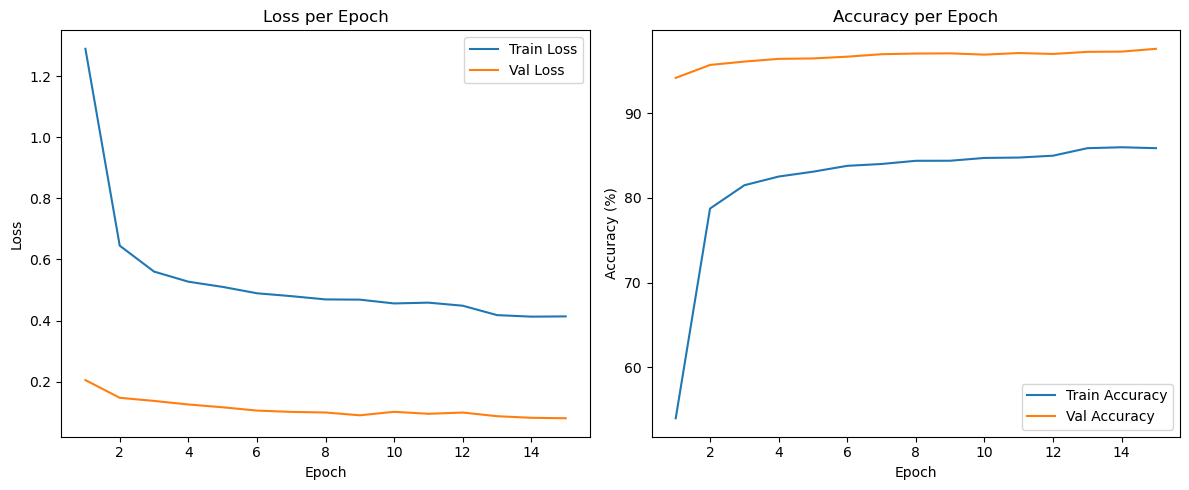

In [22]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=5,               # повороты
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


batch_size   = 32
lr           = 0.005
epochs       = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.7) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)

    for data, target in pbar:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

        pbar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    avg_loss = total_loss / len(train_loader)
    acc = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)


def test():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Validation", leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(test_loader)
    acc = 100. * correct / total
    val_losses.append(avg_loss)
    val_accuracies.append(acc)

    print(f'Val loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%')
    return avg_loss 

for epoch in range(1, epochs+1):
    train(epoch)
    print(f"Эпоха: {epoch}")
    val_loss = test()
    scheduler.step(val_loss)
    
    # scheduler.step()

torch.save(model.state_dict(), 'mnist_cnn.pth')
print('Обучение завершено и модель сохранена.')

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


## Распознование

Some number in cell 0 0. Predicted: 8


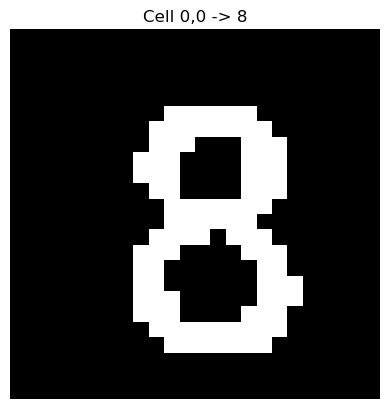

Empty cell 0 1
Empty cell 0 2
Empty cell 0 3
Some number in cell 0 4. Predicted: 1


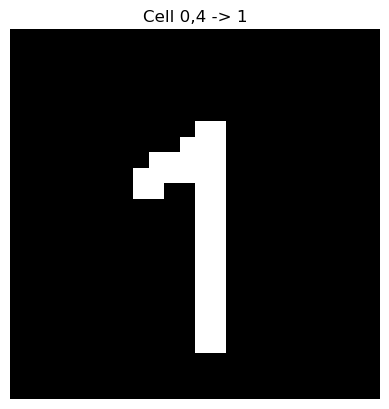

Empty cell 0 5
Empty cell 0 6
Empty cell 0 7
Some number in cell 0 8. Predicted: 9


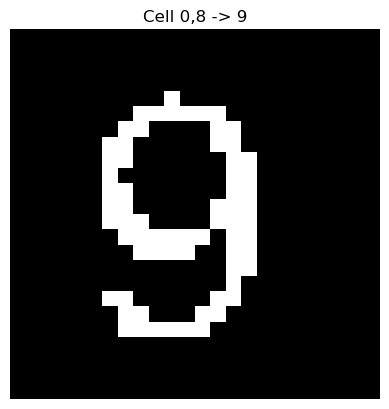

Empty cell 1 0
Some number in cell 1 1. Predicted: 5


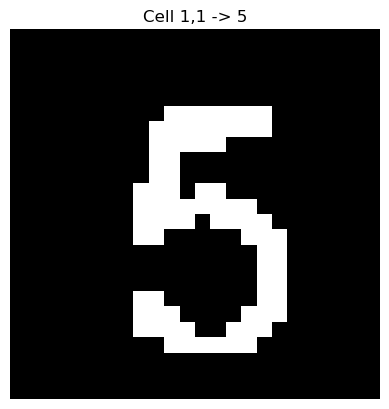

Empty cell 1 2
Some number in cell 1 3. Predicted: 8


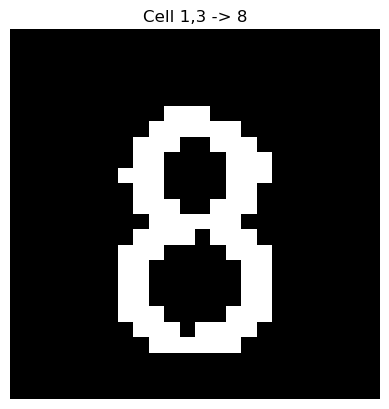

Empty cell 1 4
Some number in cell 1 5. Predicted: 7


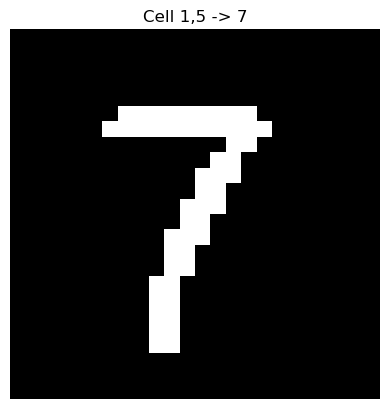

Empty cell 1 6
Some number in cell 1 7. Predicted: 1


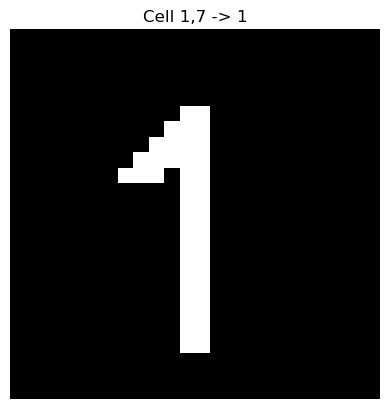

Empty cell 1 8
Empty cell 2 0
Empty cell 2 1
Some number in cell 2 2. Predicted: 4


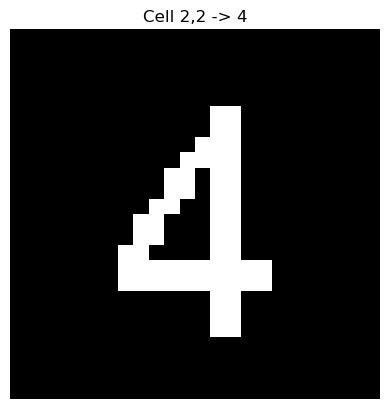

Empty cell 2 3
Some number in cell 2 4. Predicted: 9


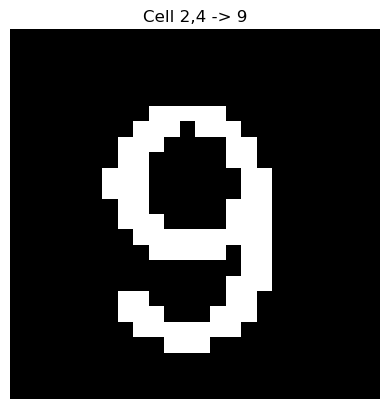

Empty cell 2 5
Some number in cell 2 6. Predicted: 7


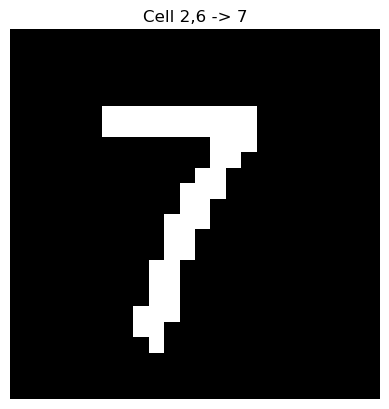

Empty cell 2 7
Empty cell 2 8
Empty cell 3 0
Some number in cell 3 1. Predicted: 6


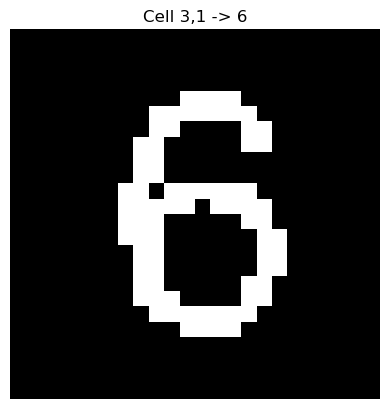

Empty cell 3 2
Some number in cell 3 3. Predicted: 7


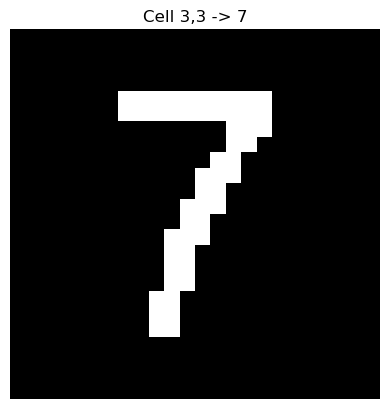

Empty cell 3 4
Some number in cell 3 5. Predicted: 1


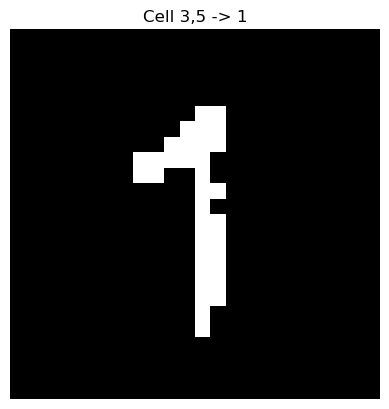

Empty cell 3 6
Some number in cell 3 7. Predicted: 2


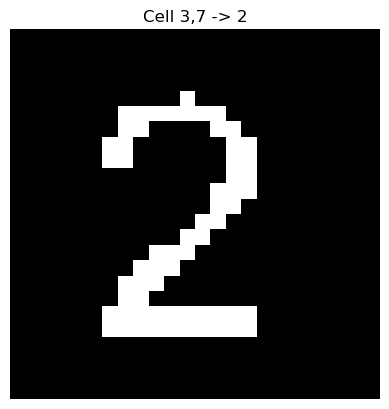

Empty cell 3 8
Some number in cell 4 0. Predicted: 5


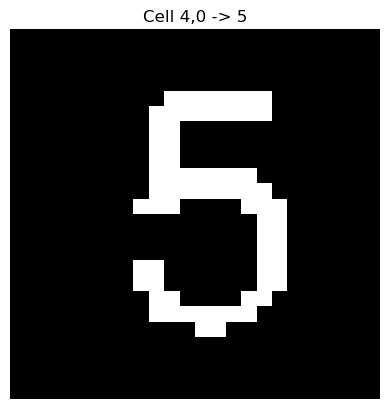

Empty cell 4 1
Some number in cell 4 2. Predicted: 8


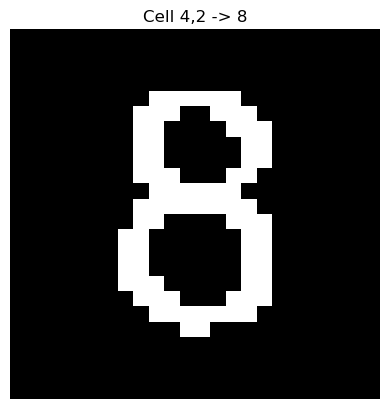

Empty cell 4 3
Some number in cell 4 4. Predicted: 6


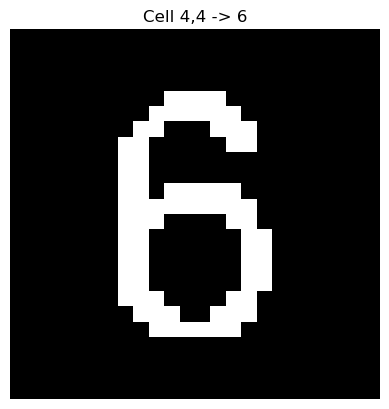

Empty cell 4 5
Some number in cell 4 6. Predicted: 1


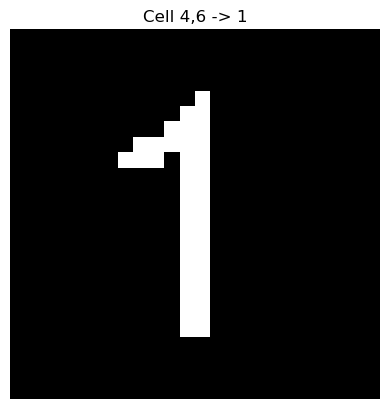

Empty cell 4 7
Some number in cell 4 8. Predicted: 7


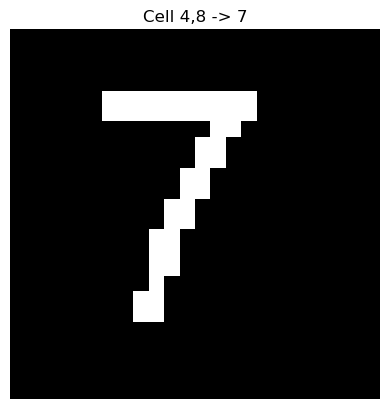

Empty cell 5 0
Some number in cell 5 1. Predicted: 1


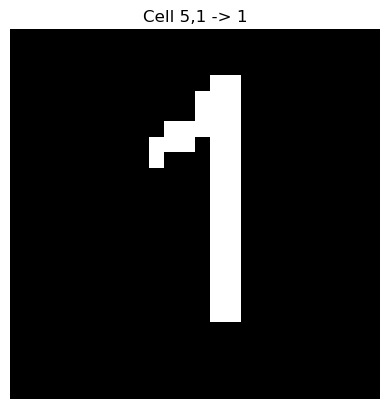

Empty cell 5 2
Some number in cell 5 3. Predicted: 5


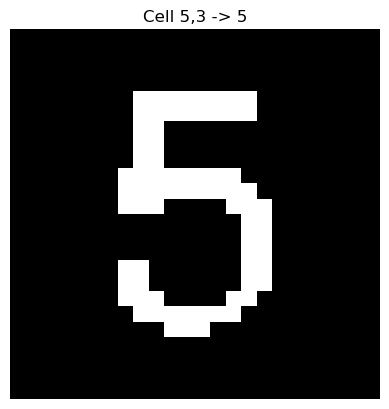

Empty cell 5 4
Some number in cell 5 5. Predicted: 2


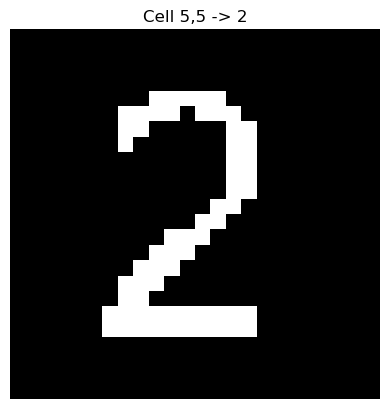

Empty cell 5 6
Some number in cell 5 7. Predicted: 9


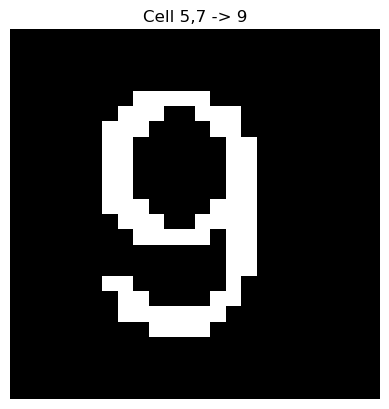

Empty cell 5 8
Empty cell 6 0
Empty cell 6 1
Some number in cell 6 2. Predicted: 7


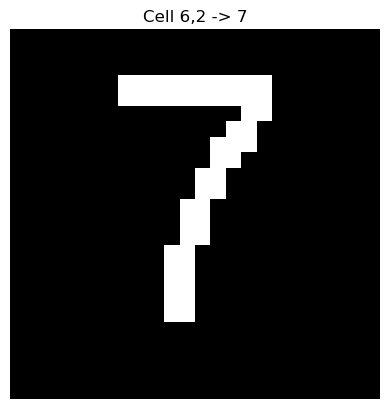

Empty cell 6 3
Some number in cell 6 4. Predicted: 4


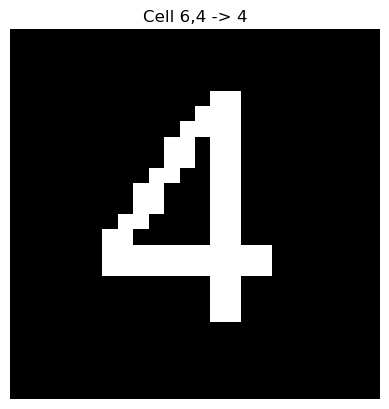

Empty cell 6 5
Some number in cell 6 6. Predicted: 6


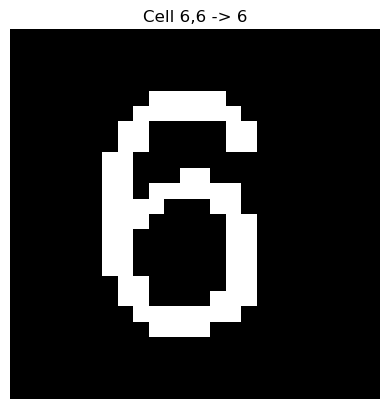

Empty cell 6 7
Empty cell 6 8
Empty cell 7 0
Some number in cell 7 1. Predicted: 8


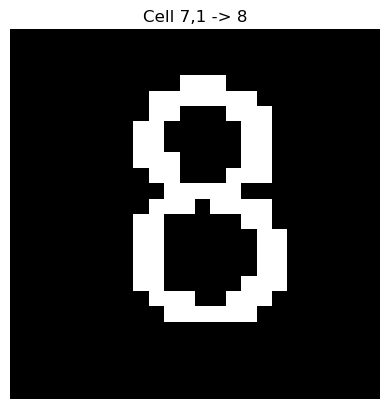

Empty cell 7 2
Some number in cell 7 3. Predicted: 3


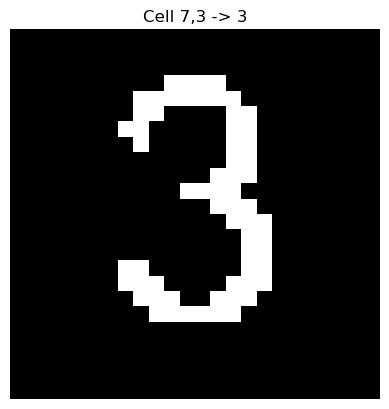

Empty cell 7 4
Some number in cell 7 5. Predicted: 9


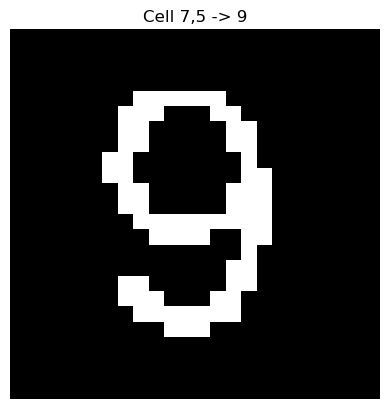

Empty cell 7 6
Some number in cell 7 7. Predicted: 4


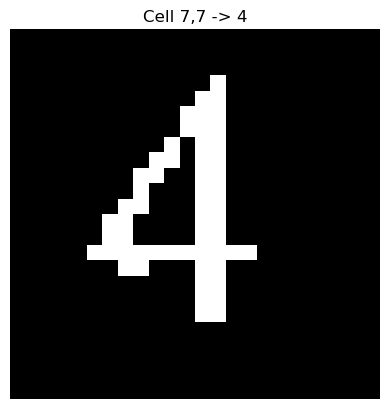

Empty cell 7 8
Some number in cell 8 0. Predicted: 3


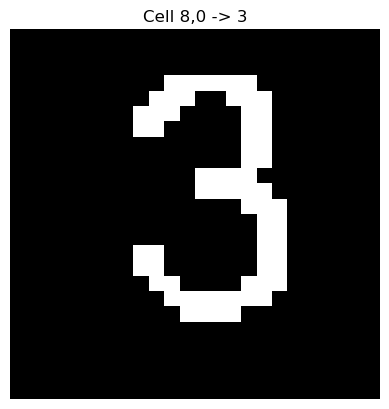

Empty cell 8 1
Empty cell 8 2
Empty cell 8 3
Some number in cell 8 4. Predicted: 5


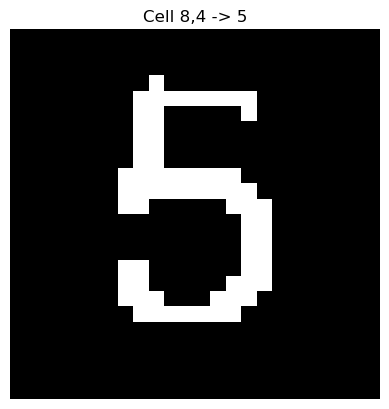

Empty cell 8 5
Empty cell 8 6
Empty cell 8 7
Some number in cell 8 8. Predicted: 8


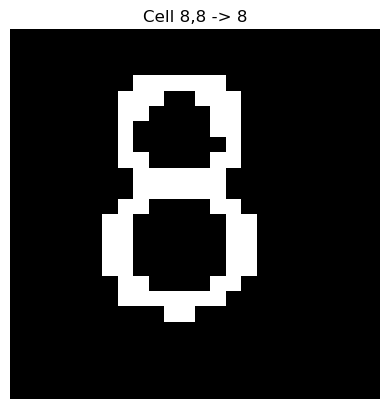

In [23]:
import matplotlib.pyplot as plt

model.eval()

for i in range(nRows):
    for j in range(nCols):
        bb = grid[i][j]  # (28, 28) numpy-массив

        if bb.sum() < 20:  # если  нет белых пикселей — пустая ячейка
            print(f"Empty cell {i} {j}")
            continue

        # Иначе — есть цифра
        tensor = preprocess_cell(bb).to(device).unsqueeze(0)  # (1, 1, 28, 28)

        with torch.no_grad():
            logits = model(tensor)
            pred = logits.argmax(1).item()

        print(f"Some number in cell {i} {j}. Predicted: {pred}")

        # Показываем изображение
        plt.imshow(bb, cmap='gray')
        plt.title(f"Cell {i},{j} -> {pred}")
        plt.axis('off')
        plt.show()


### Распознование прошло успешно!